# GA Data Science - Final Project
by Rob "Chris" Finch

### My dataset:

The dataset I've chosen for my final project is a database from Lendingtree.com about loan approvals, payment and delinquency.  The data has been anonymized, but contains copious amounts of information about the circumstances in which each loan was applied for, stats about the applicant and more.

### The Challenge:

My ultimate goal is to use machine learning techniques to build a model that predicts whether or not a loan will receive a grade of A or not.  The loan can be graded from A (best) to G (worst), depending on factors about the loan applicant's credit and work history, etc.  In this exercise, I want to focus on the A loans.  These have a substantial volume of the total number of loans in the dataset (about 17%) and I want to explore the features that make a loan receive an A grade.

## Chapter 1: Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('data/loan.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
id                             887379 non-null int64
member_id                      887379 non-null int64
loan_amnt                      887379 non-null float64
funded_amnt                    887379 non-null float64
funded_amnt_inv                887379 non-null float64
term                           887379 non-null object
int_rate                       887379 non-null float64
installment                    887379 non-null float64
grade                          887379 non-null object
sub_grade                      887379 non-null object
emp_title                      835917 non-null object
emp_length                     842554 non-null object
home_ownership                 887379 non-null object
annual_inc                     887375 non-null float64
verification_status            887379 non-null object
issue_d                        887379 non-null object
loan_status          

In [4]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As you can see, the dataset is quite enormous, at nearly 900,000 rows and almost half a gigabyte of storage space.  With some EDA techniques and minimizing some features, we will get the file size down significantly but still preserve data to make a meaningful model.

### After perusing the data, I've chosen to delete many of the features that aren't really applicable to our modeling.  

For example, in the below, I'm deleting things that only have a very small number of data points (anything to do with joint accounts, for example).

In [5]:
del data['annual_inc_joint']
del data['dti_joint']
del data['verification_status_joint']
del data['open_acc_6m']
del data['open_il_12m']
del data['open_il_24m']
del data['open_il_6m']
del data['open_rv_12m']
del data['open_rv_24m']
del data['mths_since_rcnt_il']
del data['total_bal_il']
del data['il_util']
del data['max_bal_bc']
del data['all_util']
del data['inq_fi']
del data['total_cu_tl']
del data['inq_last_12m']
del data['revol_util']
del data['last_pymnt_d']
del data['next_pymnt_d']
del data['last_credit_pull_d']

I've also chosen to delete things that aren't meaningful to our model because they're too specific, and can't be enumerated, like the applicant's job title, the URL they used to get the loan, and the description of what the money's being used for.

In [6]:
del data['emp_title']
del data['url']
del data['desc']
del data['title']

Finally, the zip code could have been useful but was partially hashed for privacy, so that's being deleted.  Additionally, I also investigated the application type and policy code features; these seemingly are some type of internal LendingTree documentation and are pretty meaningless to the outsider, so I deleted these as well.

In [7]:
del data['application_type']
del data['zip_code']
del data['policy_code']
del data['mths_since_last_record']

I'm also going to delete the subgrade column, as these will show a too-perfect correlation to our target predictor (ie. A is split into A1, A2, etc), and I don't want the model to confuse correlation with predictive capacity.

In [8]:
del data['sub_grade']

Finally, I'm removing a few more columns that appear to have absolutely no correlation to our target variable either positive or negative:

In [9]:
del data['dti']
del data['mths_since_last_delinq']
del data['mths_since_last_major_derog']
del data['collections_12_mths_ex_med']

Now that we've pared down some unnecessary columns, let's also take a look at the values themselves.  We will need to fill some empty cells with zero/"unknown" values in some cases, and records (rows) that contain empty values in others.

For the employment length feature, I've chosen to keep the data as-is but fill in the gaps with "unknown."

In [10]:
data['emp_length'] = data['emp_length'].fillna('Unknown')

Additionally, for these columns below, I've chosen to delete any row in the dataset where they're empty.  That's because there is key data missing (such as the total current balance of the loan) where keeping the data in would be harmful to our ability to model.

In [11]:
data = data[data.tot_cur_bal.notnull()]

In [12]:
data = data[data.tot_coll_amt.notnull()]

In [13]:
data = data[data.total_rev_hi_lim.notnull()]

Now if we look, we've managed to not only remove inconsistencies in the data set, but also to reduce the filesize by half:

In [14]:
data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817103 entries, 42535 to 887378
Data columns (total 40 columns):
id                         817103 non-null int64
member_id                  817103 non-null int64
loan_amnt                  817103 non-null float64
funded_amnt                817103 non-null float64
funded_amnt_inv            817103 non-null float64
term                       817103 non-null object
int_rate                   817103 non-null float64
installment                817103 non-null float64
grade                      817103 non-null object
emp_length                 817103 non-null object
home_ownership             817103 non-null object
annual_inc                 817103 non-null float64
verification_status        817103 non-null object
issue_d                    817103 non-null object
loan_status                817103 non-null object
pymnt_plan                 817103 non-null object
purpose                    817103 non-null object
addr_state                 8171

### Organizing the Data:

Now that I've cleansed the data and removed any anomalies, we can look to organize it in a way that will be most meaningful for us to analyze.

Here, I'm going to be nesting the unique Lendingtree ID as the index, and exploring some of the data types of the columns.

The loan term and employment lengths are currently objects because of the way they're notated in the data set.  I'm using key-value pairs (dictionaries) and the map method to fix these and turn them into easier-to-manipulate integers.

In [15]:
data = data.set_index('id')

In [16]:
data.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [17]:
term_remap = {' 36 months': 36, ' 60 months': 60}
data['term'] = data.term.map(term_remap)

In [18]:
data.emp_length.unique()

array(['10+ years', '1 year', '2 years', '4 years', '3 years', '7 years',
       '5 years', '6 years', '9 years', '8 years', '< 1 year', 'Unknown'],
      dtype=object)

In [19]:
emp_length_dict = {'1 year': 1, '2 years': 2, '8 years': 8, '10+ years': 10, '6 years': 6, '7 years': 7, '5 years': 5, '9 years': 9, '3 years': 3, '< 1 year': 0, 'Unknown': 0, '4 years': 4}

data['emp_length'] = data.emp_length.map(emp_length_dict)

I'm also noticing that I have a couple of columns that are still of the object type that are really dates.  So, below, I'm importing the datetime library from Pandas and converting these to time series.

In [20]:
import datetime

In [21]:
data['earliest_cr_line'] = pd.to_datetime(data.earliest_cr_line, errors='coerce')
data['issue_d'] = pd.to_datetime(data.issue_d, errors='coerce')

Finally, I want to specifically discuss the "Grade" column because that's where our analysis shall be focused. Rather than creating dummies for each grade received, all we need to do is create a new column in the dataframe that contains a numerical representation of a Boolean expression for a grade of A.  That is, a column that contains a 0 for B-G and a 1 for grades of A.  See below:

In [22]:
grade_remap = {'A': 1, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': 0}

In [23]:
data['grade_a'] = data.grade.map(grade_remap)

In [24]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817103 entries, 10149342 to 36271262
Data columns (total 40 columns):
member_id                  817103 non-null int64
loan_amnt                  817103 non-null float64
funded_amnt                817103 non-null float64
funded_amnt_inv            817103 non-null float64
term                       817103 non-null int64
int_rate                   817103 non-null float64
installment                817103 non-null float64
grade                      817103 non-null object
emp_length                 817103 non-null int64
home_ownership             817103 non-null object
annual_inc                 817103 non-null float64
verification_status        817103 non-null object
issue_d                    817103 non-null datetime64[ns]
loan_status                817103 non-null object
pymnt_plan                 817103 non-null object
purpose                    817103 non-null object
addr_state                 817103 non-null object
delinq_2yrs        

In [25]:
data.grade_a.value_counts()

0    685647
1    131456
Name: grade_a, dtype: int64

# Chapter 2: Instantiating Models

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

### Solving for Success:
It's important to discuss what success will look like for this model.  First we should think about the ultimate end-goal of using this model.  This model is taking past loan data and will likely be used to apply decisioning on how to rate future ones.  That being said, when discussing false positives and false negatives, it seems as though we'd rather have a model with more false negatives as errors.  In other words, if someone shows up as a false negative, that means they'd be knocked down a few pegs in terms of loan ratings.  If we received false positives for this study, it means that someone would be qualifying for more highly-rated loans that isn't deserving of such.

Accuracy alone isn't a great measure for this dataset, because accuracy prioritizes the weighting of importance of false positives and false negatives the same.  Since we're more comfortable with over-estimating false negatives rather than false positives, we'll look to Precision as the primary KPI for this model, while also accounting for Accuracy as a secondary KPI.

### Choosing Initial Models:

I've chosen three core models as the basis for this project: Logistic Regression, Decision Tree Classification and Random Forest Classification.  I've chosen these three and eliminated others from the mix mostly for one reason: these are model types that can accommodate value weighting the most directly.  Because my dataset for A-grades vs B-G grades is skewed (ie. out of over 810k rows, only 131k are A-grade loans, or about 17% as I previously stated), the model needs to be able to account for the skew when predicting.  K-Nearest and other types of models will continue to only choose to bring the more common variables into the test sets at random.

For all three models throughout this exercise, I will using the class_weight parameter with a setting of "balanced" to ensure that my test sets are relatively consistent with regard to the mix of A vs non-A loans.

### Choosing Features:
I've chosen the initial X feature of interest rate purely based on intuition/gut; if the exercise is to determine the grade of a loan, the first thing I would look towards is the amount of the loan.  More credit-worthy people will tend to qualify to take out larger amounts of money.

In [27]:
X = data['loan_amnt'].values.reshape(-1,1)
y = data['grade_a']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Logistic Regressor:

In [29]:
lr = LogisticRegression(class_weight='balanced')

In [30]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [31]:
lr_pred = lr.predict(X_test)

In [32]:
lr_clf = classification_report(lr_pred, y_test)

In [33]:
print("Logistic Regression - Classification Report", "\n \n", lr_clf)
print("Accuracy Score:", accuracy_score(lr_pred, y_test))

Logistic Regression - Classification Report 
 
              precision    recall  f1-score   support

          0       0.46      0.84      0.60     94773
          1       0.53      0.16      0.25    109503

avg / total       0.50      0.47      0.41    204276

Accuracy Score: 0.4745442440619554


So, right now, our Logistic Regression model is unfortunately only about as good as a coin toss.

## Decision Tree:

In [34]:
dt = DecisionTreeClassifier(max_depth=3, class_weight='balanced')

In [35]:
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_clf = classification_report(dt_pred, y_test)
print("Decision Tree - Classification Report", "\n \n", dt_clf)
print("Accuracy Score:", accuracy_score(dt_pred, y_test))

Decision Tree - Classification Report 
 
              precision    recall  f1-score   support

          0       0.18      0.93      0.30     32579
          1       0.93      0.18      0.30    171697

avg / total       0.81      0.30      0.30    204276

Accuracy Score: 0.29674557951007463


Our Decision Tree fared even worse. Let's look below to understand how it's decisioning currently a bit better:

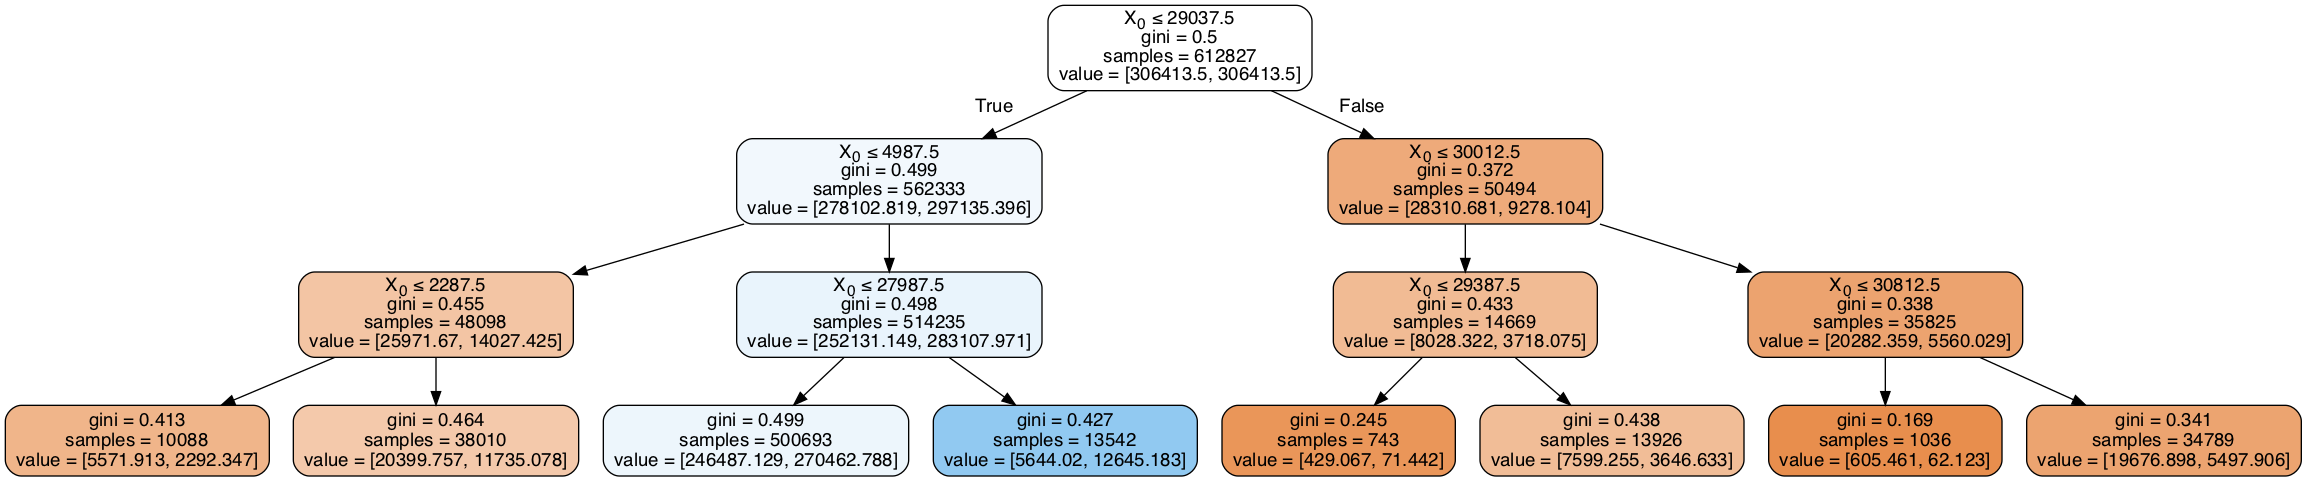

In [36]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Random Forest:

In [37]:
rf = RandomForestClassifier(class_weight='balanced', n_estimators=50)

In [38]:
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_clf = classification_report(rf_pred, y_test)
print("Random Forest - Classification Report", "\n \n", rf_clf)
print("Accuracy Score:", accuracy_score(rf_pred, y_test))

Random Forest - Classification Report 
 
              precision    recall  f1-score   support

          0       0.41      0.92      0.56     75403
          1       0.83      0.21      0.34    128873

avg / total       0.67      0.47      0.42    204276

Accuracy Score: 0.47376099003309247


### Summary Thus Far:

After pulling together our initial models, it appears that Random Forest and Logistic Regression are about as accurate as a coin flip, while Decision Trees are worse.  In the next section, we'll look to make improvements upon these.

# Chapter 3: Model Enhancement

There are a few major ways we'll look to improve and enhance our three models.  The most obvious are twofold: first, we'll leverage grid searches and pipelines against each model's hyperparameters to see how we can improve.  Then, we'll look to employ techniques of feature selection to ensure that our X axis really is the best we can be leveraging to predict A vs sub-A level loans.

## Part 1: Adding Grid Searches & Pipelines

In [39]:
from sklearn.pipeline import make_pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Logistic Regression:

In [76]:
lr_pipe = make_pipeline(PolynomialFeatures(), LogisticRegression(class_weight='balanced'))

In [77]:
lr_params = {'polynomialfeatures__degree': [i for i in range (1,10)],
         'logisticregression__C': [0.1, 1, 5, 10, 100],
            'logisticregression__class_weight': ['balanced']}

In [78]:
lr_grid = GridSearchCV(lr_pipe, param_grid=lr_params)

In [79]:
lr_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('logisticregression', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'polynomialfeatures__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'logisticregression__C': [0.1, 1, 5, 10, 100], 'logisticregression__class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [80]:
lr_grid_best = lr_grid.best_estimator_
lr_grid_pred = lr_grid_best.predict(X_test)

In [81]:
lr_grid_clf = classification_report(lr_grid_pred, y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [82]:
print("Logistic Regression - Classification Report", "\n \n", lr_grid_clf)
print("Accuracy Score:", accuracy_score(lr_grid_pred, y_test))

Logistic Regression - Classification Report 
 
              precision    recall  f1-score   support

          0       1.00      0.84      0.91    204276
          1       0.00      0.00      0.00         0

avg / total       1.00      0.84      0.91    204276

Accuracy Score: 0.8387328907948071


The pipeline has improved our model significantly above the coin toss it started with!

### Decision Tree:

In [47]:
dt_pipe = make_pipeline(PolynomialFeatures(), DecisionTreeClassifier(class_weight='balanced'))

In [48]:
dt_params = {'polynomialfeatures__degree': [i for i in range (1,5)],
         'decisiontreeclassifier__max_depth': [i for i in range (1,5)]}

In [49]:
dt_grid = GridSearchCV(dt_pipe, param_grid=dt_params)

In [50]:
dt_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('decisiontreeclassifier', DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None...     min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'polynomialfeatures__degree': [1, 2, 3, 4], 'decisiontreeclassifier__max_depth': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [51]:
dt_grid_best = dt_grid.best_estimator_
dt_grid_pred = dt_grid_best.predict(X_test)

In [52]:
dt_grid_clf = classification_report(dt_grid_pred, y_test)

In [53]:
print("Decision Tree - Classification Report", "\n \n", dt_grid_clf)
print("Accuracy Score:", accuracy_score(dt_grid_pred, y_test))

Decision Tree - Classification Report 
 
              precision    recall  f1-score   support

          0       0.18      0.93      0.30     33440
          1       0.92      0.18      0.30    170836

avg / total       0.80      0.30      0.30    204276

Accuracy Score: 0.3002163739254734


### Random Forest:

In [54]:
rf_pipe = make_pipeline(PolynomialFeatures(), RandomForestClassifier(class_weight='balanced'))

In [55]:
rf_params = {'randomforestclassifier__n_estimators': [i for i in range (1,10)]}

In [56]:
rf_grid = GridSearchCV(rf_pipe, param_grid=rf_params)

In [57]:
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_i...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'randomforestclassifier__n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [58]:
rf_grid_best = rf_grid.best_estimator_
rf_grid_pred = rf_grid_best.predict(X_test)

In [59]:
rf_grid_clf = classification_report(rf_grid_pred, y_test)

In [60]:
print("Random Forest - Classification Report", "\n \n", rf_grid_clf)
print("Accuracy Score:", accuracy_score(rf_grid_pred, y_test))

Random Forest - Classification Report 
 
              precision    recall  f1-score   support

          0       0.41      0.92      0.57     76043
          1       0.82      0.21      0.34    128233

avg / total       0.67      0.48      0.42    204276

Accuracy Score: 0.47595410131390864


Unlike the Logistic Regressor, the Decision Tree and Forest models remained largely unaided by the use of a pipeline

### Summary:

Due to the limitations we're seeming to have around class_weight, there's a limited amount of improvement that we're gleaning from exploring grid searches of optimal parameters on the tree and forest models.  The Logistic Regression model, however, has benefitted.

## Part 2: Feature Selection

Because I have so many features already, I've decided to focus solely on the numerical ones for my feature selection.

In [61]:
from sklearn.feature_selection import SelectPercentile

In [62]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = data.select_dtypes(include=numerics)

In [63]:
X_new = newdf.drop('grade_a', axis=1)

In [64]:
select_percentile = SelectPercentile(percentile=10)
select_percentile.fit(X_new, y)

SelectPercentile(percentile=10,
         score_func=<function f_classif at 0x10c95bae8>)

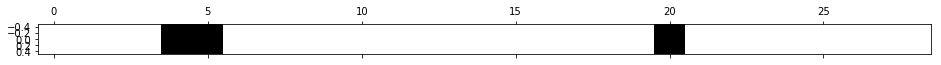

In [65]:
mask = select_percentile.get_support()
plt.matshow(mask.reshape(1, -1), cmap = 'gray_r')

In [66]:
select_percentile.get_support()

array([False, False, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False])

In [67]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817103 entries, 10149342 to 36271262
Data columns (total 30 columns):
member_id                  817103 non-null int64
loan_amnt                  817103 non-null float64
funded_amnt                817103 non-null float64
funded_amnt_inv            817103 non-null float64
term                       817103 non-null int64
int_rate                   817103 non-null float64
installment                817103 non-null float64
emp_length                 817103 non-null int64
annual_inc                 817103 non-null float64
delinq_2yrs                817103 non-null float64
inq_last_6mths             817103 non-null float64
open_acc                   817103 non-null float64
pub_rec                    817103 non-null float64
revol_bal                  817103 non-null float64
total_acc                  817103 non-null float64
out_prncp                  817103 non-null float64
out_prncp_inv              817103 non-null float64
total_pymnt        

The above SelectPercentile model appears to show that the interest rate, installment and total late fee columns are the most important features for our model.

# Chapter 4: Bringing It All Together

Now that we've investigated ways of improving our models, we can look to re-instantiate.

## Revised: Logistic Regression

In [68]:
X_optimized = data[['int_rate', 'installment', 'total_rec_late_fee']]

In [69]:
X_opt_train, X_opt_test, y_train, y_test = train_test_split(X_optimized, y)

In [70]:
lr_opt_grid = LogisticRegression(class_weight='balanced')
lr_opt_grid.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [71]:
lr_opt_pred = lr_opt_grid.predict(X_test)

In [72]:
lr_opt_clf = classification_report(lr_opt_pred, y_test)

In [73]:
print("Logistic Regression - Classification Report", "\n \n", lr_opt_clf)
print("Accuracy Score:", accuracy_score(lr_opt_pred, y_test))

Logistic Regression - Classification Report 
 
              precision    recall  f1-score   support

          0       0.46      0.84      0.60     94472
          1       0.54      0.16      0.25    109804

avg / total       0.50      0.48      0.41    204276

Accuracy Score: 0.4753911374806634


## Revised: Decision Tree

In [74]:
dt_opt = DecisionTreeClassifier(max_depth=3, class_weight='balanced')
dt_opt.fit(X_opt_train, y_train)
dt_opt_pred = dt_opt.predict(X_opt_test)
dt_opt_clf = classification_report(dt_opt_pred, y_test)
print("Decision Tree - Classification Report", "\n \n", dt_opt_clf)
print("Accuracy Score:", accuracy_score(dt_opt_pred, y_test))
print("\n")

Decision Tree - Classification Report 
 
              precision    recall  f1-score   support

          0       0.99      1.00      1.00    169841
          1       1.00      0.96      0.98     34435

avg / total       0.99      0.99      0.99    204276

Accuracy Score: 0.9926472028040494




## Revised: Random Forest

In [75]:
rf_opt = RandomForestClassifier(class_weight='balanced', n_estimators=50)
rf_opt.fit(X_opt_train, y_train)
rf_opt_pred = rf_opt.predict(X_opt_test)
rf_opt_clf = classification_report(rf_opt_pred, y_test)
print("Random Forest - Classification Report", "\n \n", rf_opt_clf)
print("Accuracy Score:", accuracy_score(rf_opt_pred, y_test))

Random Forest - Classification Report 
 
              precision    recall  f1-score   support

          0       1.00      1.00      1.00    171332
          1       1.00      1.00      1.00     32944

avg / total       1.00      1.00      1.00    204276

Accuracy Score: 0.999975523311598


# Discussion

The recalibration of the X column to include more significant features led to an almost perfect accuracy and precision rating for both the tree and forest models, but had no effect on the Logistic Regressor.

Conversely, the Logistic Regressor showed significant improvements once we were able to build a pipeline and corresponding grid search for some of its best parameters, but the feature selection had almost no effect positive or negative on this model.